In [67]:
# Aquest codi funciona amb Python en l'entorn de JupyterLab
# El dividim en apartats per a poder organitzar-nos millor les tasques del grup

In [68]:
# 1. IMPORTACI√ì DE LLIBRERIES

# Model de Predicci√≥ d'Enfrontaments - La Liga 2023-2024
print("üöÄ Iniciant Model de Predicci√≥ d'Enfrontaments...")
print("=" * 60)

# Importaci√≥ de llibreries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
# Importem molts models per a anar provant que tal van
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Configuraci√≥
plt.style.use('default')
sns.set_palette("Set2")
pd.set_option('display.max_columns', None)

print("‚úÖ Llibreries importades correctament")

üöÄ Iniciant Model de Predicci√≥ d'Enfrontaments...
‚úÖ Llibreries importades correctament


In [69]:
# 2. IMPORTACI√ì I LECTURA DE DADES

print("Carregant dades...")

# Carregament de dades
# Si fem servir la BDD fusionada excloem la columna temporada que dona problemes
df_classificacio = pd.read_excel('BDD_EntrenamentModel_Estad√≠stiques-La_Liga-FUSIONADA.xlsx', 
                                sheet_name='Classificaci√≥General').drop('Temporada', axis=1, errors='ignore')

df_partits = pd.read_excel('BDD_EntrenamentModel_Estad√≠stiques-La_Liga-FUSIONADA.xlsx', 
                           sheet_name='StatsPartit').drop('Temporada', axis=1, errors='ignore')

print(f"Dades de classificaci√≥: {df_classificacio.shape}")
print(f"Dades de partits: {df_partits.shape}")
print(f"Equips la Liga: {len(df_classificacio['Team'].unique())}")
print(f"Partits analitzats: {len(df_partits)}")


print("Equips temporada 2023-2024:")
for equip in df_classificacio['Team']:
    print(equip)
print('Dades llegides correctament')

Carregant dades...
Dades de classificaci√≥: (23, 27)
Dades de partits: (1520, 36)
Equips la Liga: 23
Partits analitzats: 1520
Equips temporada 2023-2024:
Real Madrid
Barcelona
Atl√©tico Madrid
Athletic Club
Girona
Villarreal
Real Betis
Real Sociedad
Celta Vigo
Valencia
Osasuna
Alav√©s
Rayo Vallecano
Getafe
Mallorca
Sevilla
Las Palmas
Espanyol
Legan√©s
C√°diz
Granada
Real Valladolid
Almer√≠a
Dades llegides correctament


In [70]:
# 3. FILTRATGE I TRANSFORMACI√ì DE DADES

#Aqui fusionem les dades de classificacio i partits per crear un dataframe m√©s complert
# complet amb les estad√≠stiques de cada equip
# √âs perfecte per a poder predir partits individuals i correlacions

print("PREPARACI√ì DE DADES")
print("=" * 50)

# Funci√≥ per obtenir estad√≠stiques d'un equip
def obtenir_stats_equip(equip_nom, df_classificacio):
    """Obtenim les estad√≠stiques d'un equip espec√≠fic"""
    if equip_nom in df_classificacio['Team'].values:
        return df_classificacio[df_classificacio['Team'] == equip_nom].iloc[0]
    else:
        # Si no trobem l'equip, retornem valors mitjans
        return df_classificacio.mean()

# Funci√≥ per crear features dels equips
def crear_features_equips(df_partits, df_classificacio):
    """Creem features combinant estad√≠stiques dels equips amb dades de partits"""
    df_nou = df_partits.copy()
    
    # Columnes de classificaci√≥ (excloent 'Team')
    stats_columns = [col for col in df_classificacio.columns if col != 'Team']
    
    # Afegim estad√≠stiques de l'equip local
    for col in stats_columns:
        df_nou[f'Home_{col}'] = df_nou['Home Team'].map(
            df_classificacio.set_index('Team')[col]
        ).fillna(df_classificacio[col].mean())
    
    # Afegim estad√≠stiques de l'equip visitant
    for col in stats_columns:
        df_nou[f'Away_{col}'] = df_nou['Away Team'].map(
            df_classificacio.set_index('Team')[col]
        ).fillna(df_classificacio[col].mean())
    
    return df_nou

print("Preparant dades...")

# Apliquem la funci√≥
df_complet = crear_features_equips(df_partits, df_classificacio)

print(f"‚úÖ Dataset complet creat: {df_complet.shape}")
print(f"üìä Features dels equips: {len([col for col in df_complet.columns if col.startswith('Home_') or col.startswith('Away_')])}")

# Creaci√≥ de variables objectiu
print("\nüéØ Creant variables objectiu...")

# Variables objectiu
df_complet['Victory'] = (df_complet['Home Goal'] > df_complet['Away Goal']).astype(int)
df_complet['Draw'] = (df_complet['Home Goal'] == df_complet['Away Goal']).astype(int)
df_complet['Total_Goals'] = df_complet['Home Goal'] + df_complet['Away Goal']
df_complet['Goal_Difference'] = df_complet['Home Goal'] - df_complet['Away Goal']

# Resultat categ√≤ric
def crear_resultat_categoric(row):
    if row['Home Goal'] > row['Away Goal']:
        return 'Home_Win'
    elif row['Home Goal'] < row['Away Goal']:
        return 'Away_Win'
    else:
        return 'Draw'

df_complet['Result'] = df_complet.apply(crear_resultat_categoric, axis=1)

# Mostrem estad√≠stiques
print("\nüìà Estad√≠stiques de les variables objectiu:")
print(f"- Vict√≤ries locals: {df_complet['Victory'].sum()} ({df_complet['Victory'].mean():.1%})")
print(f"- Empats: {df_complet['Draw'].sum()} ({df_complet['Draw'].mean():.1%})")
print(f"- Gols totals (mitjana): {df_complet['Total_Goals'].mean():.2f}")
print(f"- Corners (mitjana): {df_complet['wonCorners'].mean():.1f}")

print("\nüèÜ Distribuci√≥ de resultats:")
for resultat, count in df_complet['Result'].value_counts().items():
    print(f"  {resultat}: {count} ({count/len(df_complet):.1%})")

# Selecci√≥ de features per al model
print("\nüîç Seleccionant features...")

# Features del partit
features_partit_cols = [
    'foulsCommitted', 'yellowCards', 'redCards', 'offsides', 'wonCorners',
    'saves', 'possessionPct', 'totalShots', 'shotsOnTarget', 'shotPct',
    'penaltyKickGoals', 'penaltyKickShots', 'accuratePasses', 'totalPasses',
    'passPct', 'accurateCrosses', 'totalCrosses', 'crossPct', 'accurateLongBalls',
    'totalLongBalls', 'longballPct', 'blockedShots', 'effectiveTackles',
    'totalTackles', 'tacklePct', 'interceptions', 'effectiveClearance', 'totalClearance'
]

# Features dels equips
features_equips = [col for col in df_complet.columns if col.startswith('Home_') or col.startswith('Away_')]

# Combinem totes les features
X_features = features_partit_cols + features_equips

# Dataset final per al model
df_model = df_complet[X_features + ['Victory', 'Total_Goals', 'wonCorners', 'Result','homeAway']].dropna()
# Esborrem WonCorners que la teniem duplicada i donava molts problemes
df_model = df_model.loc[:, ~df_model.columns.duplicated()]


X = df_model[X_features]
y_victory = df_model['Victory']
y_goals = df_model['Total_Goals']
y_corners = df_model['wonCorners']
y_result = df_model['Result']

print(f"‚úÖ Dataset final: {df_model.shape}")
print(f"üìä Features utilitzades: {len(X_features)}")
print(f"ÔøΩÔøΩ Variables objectiu: Vict√≤ria, Gols Totals, Corners, Resultat")

PREPARACI√ì DE DADES
Preparant dades...
‚úÖ Dataset complet creat: (1520, 88)
üìä Features dels equips: 52

üéØ Creant variables objectiu...

üìà Estad√≠stiques de les variables objectiu:
- Vict√≤ries locals: 672 (44.2%)
- Empats: 408 (26.8%)
- Gols totals (mitjana): 2.63
- Corners (mitjana): 4.7

üèÜ Distribuci√≥ de resultats:
  Home_Win: 672 (44.2%)
  Away_Win: 440 (28.9%)
  Draw: 408 (26.8%)

üîç Seleccionant features...
‚úÖ Dataset final: (1520, 84)
üìä Features utilitzades: 80
ÔøΩÔøΩ Variables objectiu: Vict√≤ria, Gols Totals, Corners, Resultat


AN√ÄLISI DE VARIABLES I CORRELACIONS

Top 15 correlacions amb Victory:
1. Home_M_HomeGF: 0.333
2. Home_Home GF: 0.333
3. Home_M_GolsF: 0.328
4. Home_GF: 0.328
5. Home_%_CS: 0.316
6. Home_Clean Sheets: 0.316
7. Away_M_GolsF: -0.308
8. Away_GF: -0.308
9. Away_Home GF: -0.306
10. Away_M_HomeGF: -0.306
11. Home_Home Clean Sheets: 0.291
12. Away_%_CS: -0.287
13. Away_Clean Sheets: -0.287
14. Away_Home Clean Sheets: -0.259
15. Away_MP: -0.220


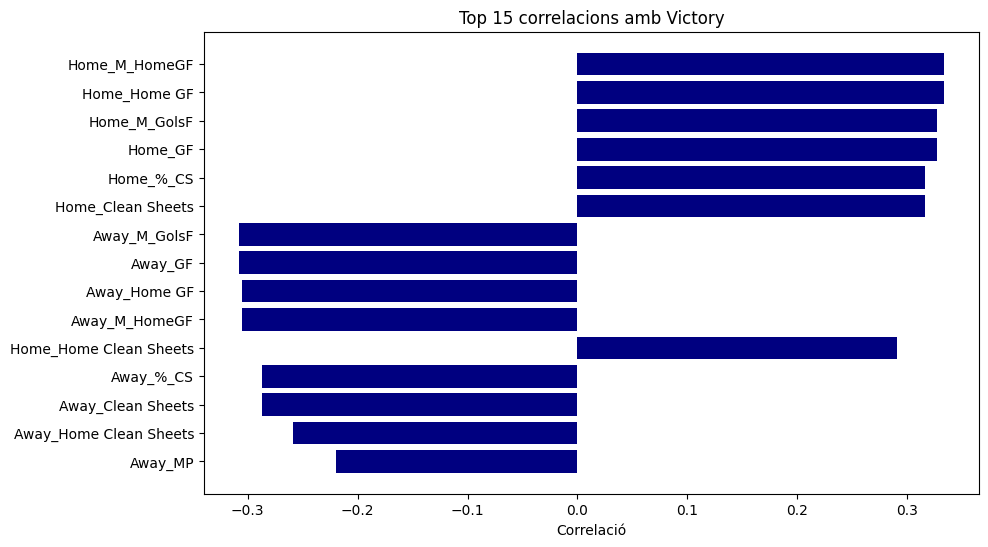


Top 15 correlacions amb Total_Goals:
1. shotsOnTarget: 0.399
2. Home_Home GF: 0.243
3. Home_M_HomeGF: 0.243
4. Home_M_GolsF: 0.230
5. Home_GF: 0.230
6. penaltyKickGoals: 0.207
7. penaltyKickShots: 0.187
8. totalLongBalls: -0.165
9. totalShots: 0.160
10. totalClearance: -0.133
11. effectiveClearance: -0.133
12. shotPct: 0.128
13. Away_%_HomeGoals: -0.127
14. accuratePasses: 0.115
15. Home_Home GA: 0.098


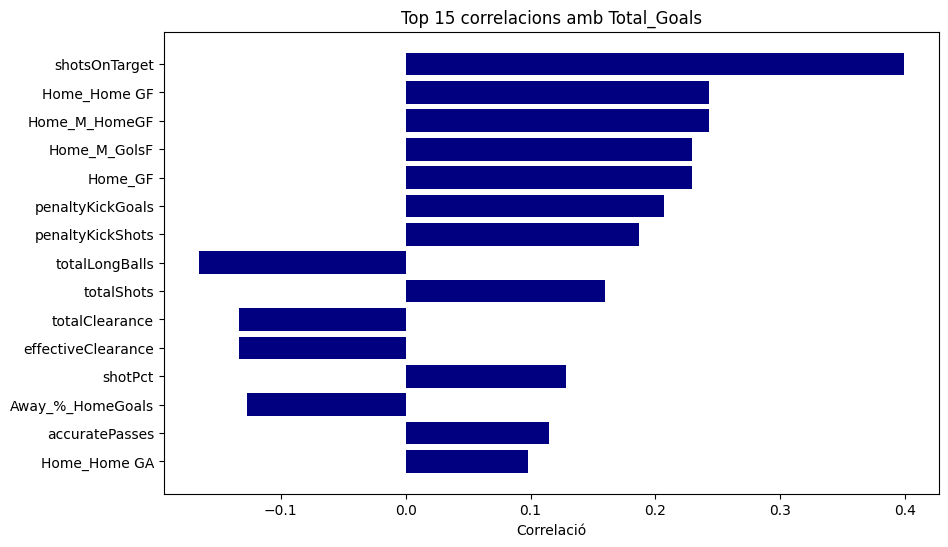

‚ö†Ô∏è La columna Goal_Difference no existeix!


In [71]:
# 4. AN√ÄLISI DE VARIABLES I CORRELACIONS

print("AN√ÄLISI DE VARIABLES I CORRELACIONS")
print("=" * 50)

targets = ['Victory', 'Total_Goals', 'Goal_Difference']

# Codifiquem homeAway: 1 si juga a casa, 0 si juga fora
df_model['isHome'] = df_model['homeAway'].map({'home': 1, 'away': 0})

# Variables a excloure (derivades de resultats)
excloure_vars = [
    'Home_Victory', 'Home_%_Victories', 'Home_Empats', 'Home_%_Empats',
    'Home_Derrotes', 'Home_%_Derrotes', 'Home_GD', 'Home_Home Win',
    'Home_%_HomeWin', 'Home_Home Draw', 'Home_%_HomeDraw', 'Home_Home Loss',
    'Home_%_HomeLoss', 'Away_Victory', 'Away_%_Victories', 'Away_Empats',
    'Away_%_Empats', 'Away_Derrotes', 'Away_%_Derrotes', 'Away_GD',
    'Away_Home Win', 'Away_%_HomeWin', 'Away_Home Draw', 'Away_%_HomeDraw',
    'Away_Home Loss', 'Away_%_HomeLoss'
]

# Columnes num√®riques de df_model
numeric_cols = df_model.select_dtypes(include='number').columns.tolist()

# Filtrar excloent variables derivades de resultat
features_cols = [col for col in numeric_cols if col not in excloure_vars + targets]

for target in targets:
    if target not in df_model.columns:
        print(f"‚ö†Ô∏è La columna {target} no existeix!")
        continue

    print(f"\nTop 15 correlacions amb {target}:")
    corr = df_model[features_cols + [target]].corr()[target].drop(target, errors='ignore')
    corr_abs_sorted = corr.abs().sort_values(ascending=False)
    top15 = corr_abs_sorted.head(15).index.tolist()

    for i, col in enumerate(top15, 1):
        print(f"{i}. {col}: {corr[col]:.3f}")

    plt.figure(figsize=(10, 6))
    values = corr[top15]
    plt.barh(range(len(values)), values.values, color='navy')
    plt.yticks(range(len(values)), top15)
    plt.xlabel('Correlaci√≥')
    plt.title(f'Top 15 correlacions amb {target}')
    plt.gca().invert_yaxis()
    plt.show()


In [72]:
# 5. ENTRENAMENT I FORMACI√ì DELS MODELS PREDICTIUS

# !!! ELS MODELS VAN FATAL DE MOMENT EXCEPTE EL DE VICT√íRIA
# HEM DE TREURE VARIABLES DEL df_model NO RELLEVANTS FIXANT-NOS EN LES CORRELACIONS
# PODEM PROVAR TAMB√â ALTRES TIPUS DE MODELS COM:
# Gradient Boosting (XGBoost, LightGBM), SVM, xarxes neuronals, o models ensemble.


print("ENTRENAMENT DE MODELS")
print("=" * 50)

# Eliminar duplicats de columnes a X
# El problema que teniem en el seg√ºent bloc era que Won_corners estava duplicat.
# Afegint aix√≤ borrem columnes duplicades i ja no salta error
X = X.loc[:, ~X.columns.duplicated()]

# Assignar noms de features reals
X_features = X.columns.tolist()

# Divisi√≥ de dades
print("üîÑ Dividint dades en entrenament i test...")

X_train, X_test, y_victory_train, y_victory_test = train_test_split(
    X, y_victory, test_size=0.2, random_state=42, stratify=y_victory
)

_, _, y_goals_train, y_goals_test = train_test_split(
    X, y_goals, test_size=0.2, random_state=42
)

_, _, y_corners_train, y_corners_test = train_test_split(
    X, y_corners, test_size=0.2, random_state=42
)

_, _, y_result_train, y_result_test = train_test_split(
    X, y_result, test_size=0.2, random_state=42, stratify=y_result
)

print(f"üìö Dades d'entrenament: {X_train.shape}")
print(f"üß™ Dades de test: {X_test.shape}")

# Entrenament dels models
print("\nü§ñ ENTRENAMENT DELS MODELS")
print("=" * 50)


# Model 1: Predicci√≥ de vict√≤ria
print("\n1Ô∏è‚É£ Model de Predicci√≥ de Vict√≤ria")
# Deixo el codi del RandomForest anulat per no haver d'anar escrivint sempre que volem canviar
# De moment LogisticRegression i RandomForest donen exactament la mateixa precisi√≥
model_victory = RandomForestClassifier(n_estimators=100, random_state=42)
# model_victory = LogisticRegression(max_iter=5000, random_state=42)
model_victory.fit(X_train, y_victory_train)
victory_pred = model_victory.predict(X_test)
victory_accuracy = accuracy_score(y_victory_test, victory_pred)
print(f"   ‚úÖ Precisi√≥: {victory_accuracy:.3f}")

# Model 2: Predicci√≥ de gols totals
print("\n2Ô∏è‚É£ Model de Predicci√≥ de Gols Totals")
# Deixo el codi del RandomForest anulat per no haver d'anar escrivint sempre que volem canviar
model_goals = RandomForestRegressor(n_estimators=100, random_state=42)
# model_goals = HistGradientBoostingRegressor(random_state=42)
model_goals.fit(X_train, y_goals_train)
goals_pred = model_goals.predict(X_test)
goals_mse = mean_squared_error(y_goals_test, goals_pred)
print(f"   ‚úÖ RMSE: {np.sqrt(goals_mse):.3f}")

# Model 3: Predicci√≥ de corners
print("\n3Ô∏è‚É£ Model de Predicci√≥ de Corners")
model_corners = RandomForestRegressor(n_estimators=100, random_state=42)
model_corners.fit(X_train, y_corners_train)
corners_pred = model_corners.predict(X_test)
corners_mse = mean_squared_error(y_corners_test, corners_pred)
print(f"   ‚úÖ RMSE: {np.sqrt(corners_mse):.3f}")

# Model 4: Predicci√≥ de resultat complet
print("\n4Ô∏è‚É£ Model de Predicci√≥ de Resultat")
model_result = RandomForestClassifier(n_estimators=100, random_state=42)
model_result.fit(X_train, y_result_train)
result_pred = model_result.predict(X_test)
result_accuracy = accuracy_score(y_result_test, result_pred)
print(f"   ‚úÖ Precisi√≥: {result_accuracy:.3f}")

print("\nüìä Report de classificaci√≥ (Resultat):")
print(classification_report(y_result_test, result_pred))
# En precisi√≥, com m√©s alt millor
# En RMSE com m√©s baix millor: RMSE de 2 vol dir que s'equivoca en dues unitats
# Si s'equivoca de dos gols √©s molt dolent

ENTRENAMENT DE MODELS
üîÑ Dividint dades en entrenament i test...
üìö Dades d'entrenament: (1216, 80)
üß™ Dades de test: (304, 80)

ü§ñ ENTRENAMENT DELS MODELS

1Ô∏è‚É£ Model de Predicci√≥ de Vict√≤ria
   ‚úÖ Precisi√≥: 0.789

2Ô∏è‚É£ Model de Predicci√≥ de Gols Totals
   ‚úÖ RMSE: 1.858

3Ô∏è‚É£ Model de Predicci√≥ de Corners
   ‚úÖ RMSE: 2.881

4Ô∏è‚É£ Model de Predicci√≥ de Resultat
   ‚úÖ Precisi√≥: 0.543

üìä Report de classificaci√≥ (Resultat):
              precision    recall  f1-score   support

    Away_Win       0.41      0.38      0.39        88
        Draw       0.33      0.28      0.30        82
    Home_Win       0.71      0.81      0.76       134

    accuracy                           0.54       304
   macro avg       0.48      0.49      0.48       304
weighted avg       0.52      0.54      0.53       304




üîç AN√ÄLISI D'IMPORT√ÄNCIA DE FEATURES

üèÜ Top 10 features per a predicci√≥ de vict√≤ria:
  17. totalCrosses              0.0258
  30. Home_Victory              0.0238
  28. totalClearance            0.0238
  14. totalPasses               0.0233
  27. effectiveClearance        0.0231
  40. Home_GD                   0.0227
  13. accuratePasses            0.0226
   7. possessionPct             0.0224
  44. Home_Home Win             0.0203
  20. totalLongBalls            0.0200

‚öΩ Top 10 features per a predicci√≥ de gols:
  19. accurateLongBalls         0.0442
   7. possessionPct             0.0418
  20. totalLongBalls            0.0390
  17. totalCrosses              0.0389
  13. accuratePasses            0.0335
  26. interceptions             0.0333
  24. totalTackles              0.0319
   8. totalShots                0.0314
  14. totalPasses               0.0311
   1. foulsCommitted            0.0307


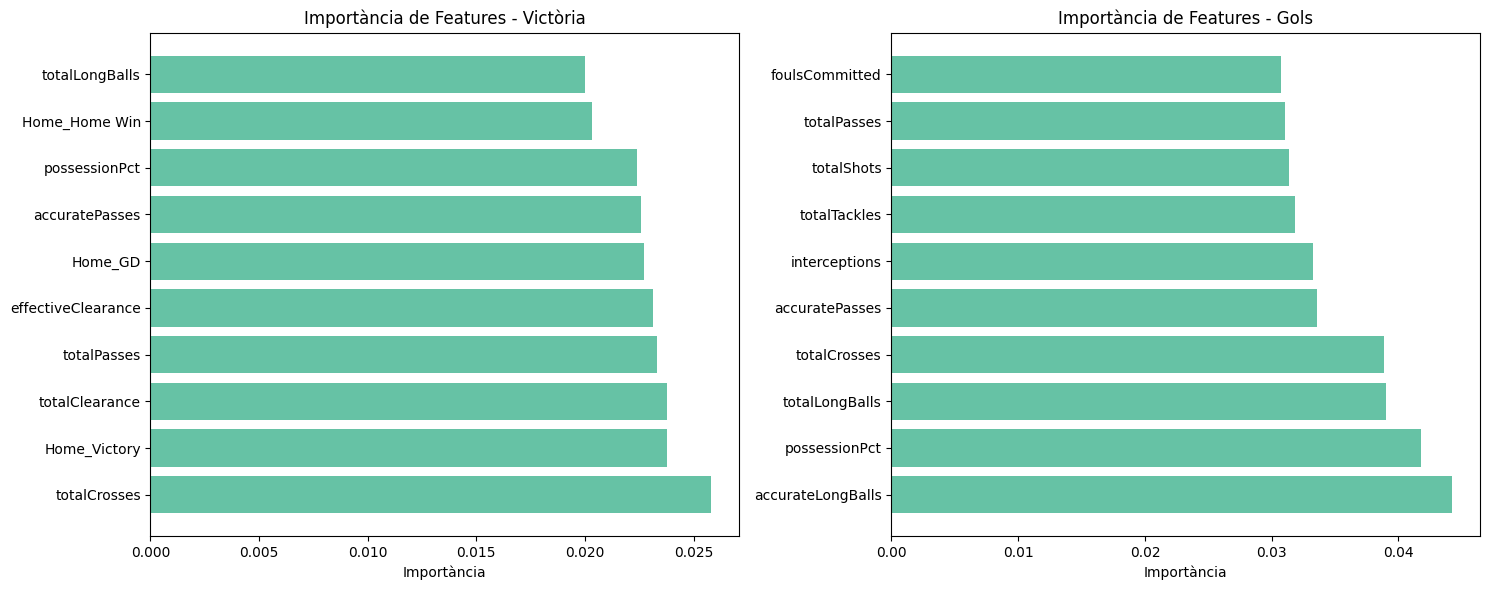


üìä AN√ÄLISI DE RENDIMENT


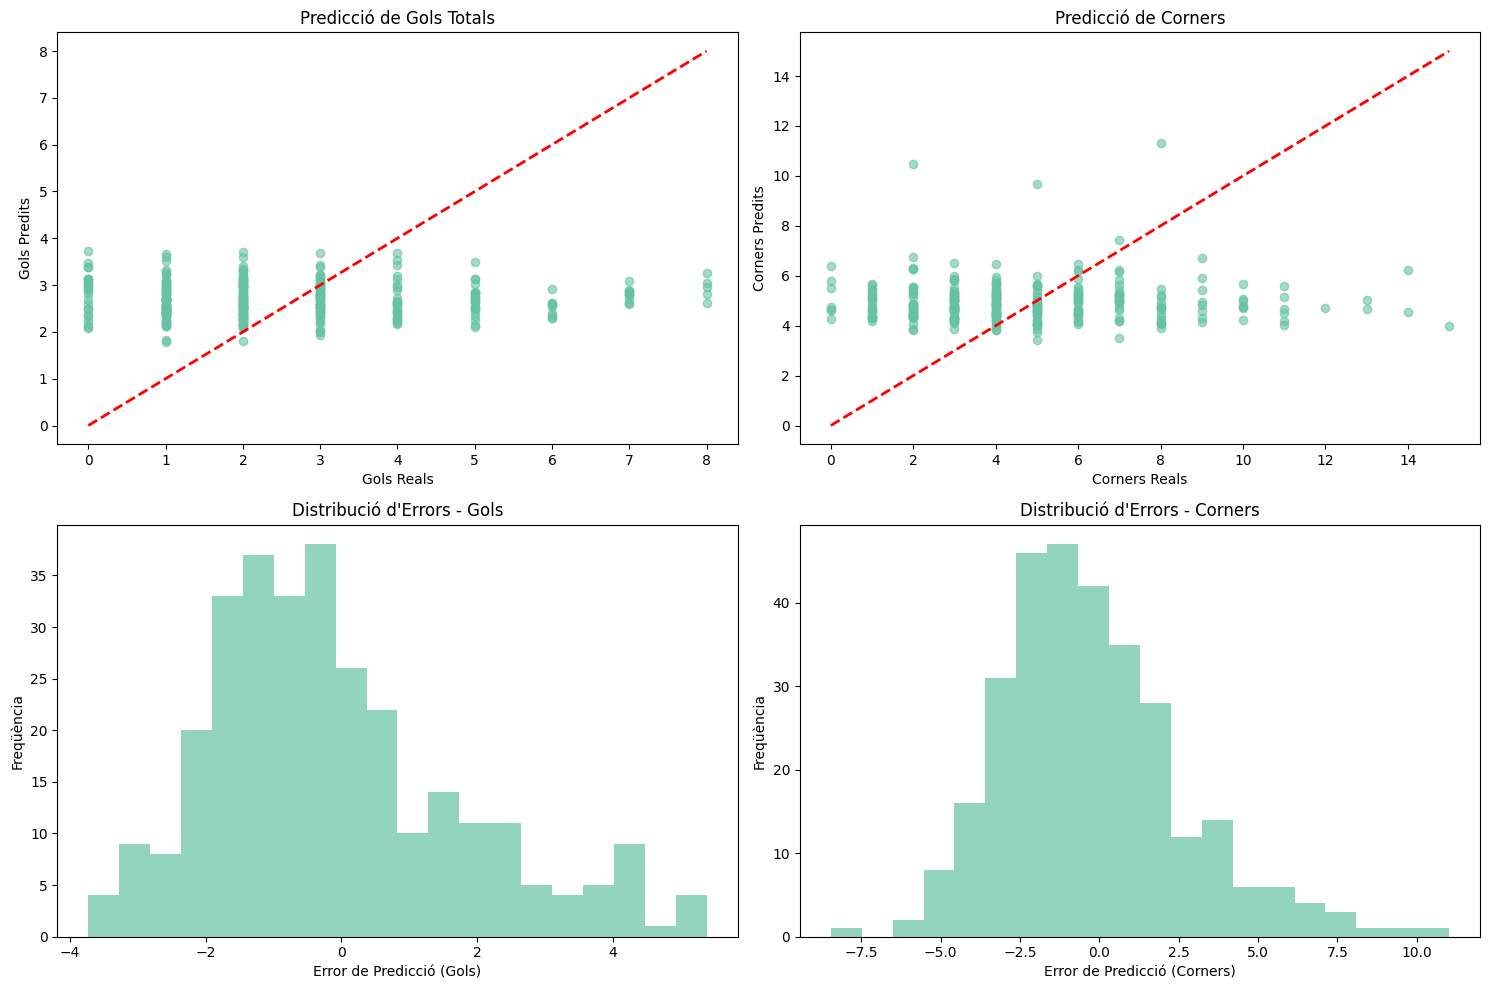


ÔøΩÔøΩ Resum de rendiment dels models:
- Precisi√≥ vict√≤ria: 78.9%
- RMSE gols: 1.86
- RMSE corners: 2.88
- Precisi√≥ resultat: 54.3%


In [73]:
# 6. AN√ÄLISI D'IMPORT√ÄNCIA DE FEATURES

# Aquest apartat √©s similar al de les correlacions per√≤ ja dins dels models predictius

print("\nüîç AN√ÄLISI D'IMPORT√ÄNCIA DE FEATURES")
print("=" * 50)

# Obtenim import√†ncia per a cada model
feature_importance_victory = pd.DataFrame({
    'feature': X_features,
    'importance': model_victory.feature_importances_
}).sort_values('importance', ascending=False)

feature_importance_goals = pd.DataFrame({
    'feature': X_features,
    'importance': model_goals.feature_importances_
}).sort_values('importance', ascending=False)

print("\nüèÜ Top 10 features per a predicci√≥ de vict√≤ria:")
for i, row in feature_importance_victory.head(10).iterrows():
    print(f"  {i+1:2d}. {row['feature']:<25} {row['importance']:.4f}")

print("\n‚öΩ Top 10 features per a predicci√≥ de gols:")
for i, row in feature_importance_goals.head(10).iterrows():
    print(f"  {i+1:2d}. {row['feature']:<25} {row['importance']:.4f}")

# Visualitzaci√≥ de la import√†ncia de features
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
top_features_victory = feature_importance_victory.head(10)
plt.barh(range(len(top_features_victory)), top_features_victory['importance'])
plt.yticks(range(len(top_features_victory)), top_features_victory['feature'])
plt.title('Import√†ncia de Features - Vict√≤ria')
plt.xlabel('Import√†ncia')

plt.subplot(1, 2, 2)
top_features_goals = feature_importance_goals.head(10)
plt.barh(range(len(top_features_goals)), top_features_goals['importance'])
plt.yticks(range(len(top_features_goals)), top_features_goals['feature'])
plt.title('Import√†ncia de Features - Gols')
plt.xlabel('Import√†ncia')

plt.tight_layout()
plt.show()

# An√†lisi de rendiment dels models
print("\nüìä AN√ÄLISI DE RENDIMENT")
print("=" * 50)

# Comparaci√≥ de prediccions vs valors reals
plt.figure(figsize=(15, 10))

# Predicci√≥ de gols
plt.subplot(2, 2, 1)
plt.scatter(y_goals_test, goals_pred, alpha=0.6)
plt.plot([y_goals_test.min(), y_goals_test.max()], [y_goals_test.min(), y_goals_test.max()], 'r--', lw=2)
plt.xlabel('Gols Reals')
plt.ylabel('Gols Predits')
plt.title('Predicci√≥ de Gols Totals')

# Predicci√≥ de corners
plt.subplot(2, 2, 2)
plt.scatter(y_corners_test, corners_pred, alpha=0.6)
plt.plot([y_corners_test.min(), y_corners_test.max()], [y_corners_test.min(), y_corners_test.max()], 'r--', lw=2)
plt.xlabel('Corners Reals')
plt.ylabel('Corners Predits')
plt.title('Predicci√≥ de Corners')

# Distribuci√≥ d'errors de gols
plt.subplot(2, 2, 3)
errors_goals = y_goals_test - goals_pred
plt.hist(errors_goals, bins=20, alpha=0.7)
plt.xlabel('Error de Predicci√≥ (Gols)')
plt.ylabel('Freq√º√®ncia')
plt.title('Distribuci√≥ d\'Errors - Gols')

# Distribuci√≥ d'errors de corners
plt.subplot(2, 2, 4)
errors_corners = y_corners_test - corners_pred
plt.hist(errors_corners, bins=20, alpha=0.7)
plt.xlabel('Error de Predicci√≥ (Corners)')
plt.ylabel('Freq√º√®ncia')
plt.title('Distribuci√≥ d\'Errors - Corners')

plt.tight_layout()
plt.show()

# Resum de m√®triques
print(f"\nÔøΩÔøΩ Resum de rendiment dels models:")
print(f"- Precisi√≥ vict√≤ria: {victory_accuracy:.1%}")
print(f"- RMSE gols: {np.sqrt(goals_mse):.2f}")
print(f"- RMSE corners: {np.sqrt(corners_mse):.2f}")
print(f"- Precisi√≥ resultat: {result_accuracy:.1%}")

In [74]:
duplicades = df_model.columns[df_model.columns.duplicated()].tolist()
print("Columnes duplicades:", duplicades)

Columnes duplicades: []


In [75]:
# 7. DEFINICI√ì DE LES FUNCIONS PREDICTIVES DELS MODELS

print("FUNCI√ì DE PREDICCI√ì")
print("=" * 50)

# Funci√≥ per fer prediccions
def predir_partit(equip_local, equip_visitant, df_classificacio, df_model, X_features, models):
    """
    Prediu el resultat d'un partit espec√≠fic
    """
    
    # Obtenim estad√≠stiques dels equips
    stats_local = df_classificacio[df_classificacio['Team'] == equip_local]
    stats_visitant = df_classificacio[df_classificacio['Team'] == equip_visitant]
    
    if stats_local.empty or stats_visitant.empty:
        print(f"‚ö†Ô∏è  No s'han trobat les dades per a {equip_local} o {equip_visitant}")
        return None
    
    # Creem vector de features
    features_partit = {}
    
    # Estad√≠stiques dels equips
    for col in df_classificacio.columns:
        if col != 'Team':
            features_partit[f'Home_{col}'] = float(stats_local[col].values[0])
            features_partit[f'Away_{col}'] = float(stats_visitant[col].values[0])

    # Valors mitjans per a estad√≠stiques del partit
    for col in X_features:
        if col not in features_partit:
            features_partit[col] = float(df_model[col].mean())

    
    # Convertim a DataFrame
    df_prediccio = pd.DataFrame([features_partit])
    X_prediccio = df_prediccio[X_features]
    
    # Fem prediccions
    prob_victory = models['victory'].predict_proba(X_prediccio)[0][1]
    pred_goals = models['goals'].predict(X_prediccio)[0]
    pred_corners = models['corners'].predict(X_prediccio)[0]
    pred_result = models['result'].predict(X_prediccio)[0]
    
    return {
        'equip_local': equip_local,
        'equip_visitant': equip_visitant,
        'probabilitat_victoria_local': f"{prob_victory:.1%}",
        'gols_totals_previstos': f"{pred_goals:.1f}",
        'corners_previstos': f"{pred_corners:.1f}",
        'resultat_previst': pred_result
    }

    # Diccionari amb els models
models = {
    'victory': model_victory,
    'goals': model_goals,
    'corners': model_corners,
    'result': model_result
}

FUNCI√ì DE PREDICCI√ì


In [76]:




print("EXEMPLES DE PREDICCI√ì")
print("=" * 50)

# Exemple 1
print("\nüèÜ Real Madrid vs Barcelona:")
prediccio1 = predir_partit('Real Madrid', 'Barcelona', df_classificacio, df_model, X_features, models)
if prediccio1:
    for key, value in prediccio1.items():
        print(f"  {key}: {value}")

# Exemple 2
print("\n‚öΩ Girona vs Atl√©tico Madrid:")
prediccio2 = predir_partit('Girona', 'Atl√©tico Madrid', df_classificacio, df_model, X_features, models)
if prediccio2:
    for key, value in prediccio2.items():
        print(f"  {key}: {value}")

# Exemple 3
print("\nüîµ Barcelona vs Real Madrid:")
prediccio3 = predir_partit('Barcelona', 'Real Madrid', df_classificacio, df_model, X_features, models)
if prediccio3:
    for key, value in prediccio3.items():
        print(f"  {key}: {value}")

# Funci√≥ per fer prediccions personalitzades
def fer_prediccio_personalitzada():
    """
    Funci√≥ interactiva per fer prediccions personalitzades
    """
    print("\nüí¨ Predicci√≥ Personalitzada")
    print("-" * 30)
    
    # Mostrem equips disponibles
    print("üìã Equips disponibles:")
    for i, equip in enumerate(df_classificacio['Team'].values, 1):
        print(f"  {i:2d}. {equip}")
    
    # Demanem equips
    try:
        equip_local = input("\nüè† Equip local: ")
        equip_visitant = input("‚úàÔ∏è  Equip visitant: ")
        
        # Fem la predicci√≥
        prediccio = predir_partit(equip_local, equip_visitant, df_classificacio, df_model, X_features, models)
        
        if prediccio:
            print(f"\nüéØ PREDICCI√ì: {equip_local} vs {equip_visitant}")
            print("=" * 40)
            for key, value in prediccio.items():
                print(f"  {key}: {value}")
        else:
            print("‚ùå No s'ha pogut fer la predicci√≥. Verifica els noms dels equips.")
            
    except KeyboardInterrupt:
        print("\nüõë Fi del programa")
    except Exception as e:
        print(f"‚ùå Error: {e}")

print("\nüí° Per fer prediccions personalitzades, executa: fer_prediccio_personalitzada()")


EXEMPLES DE PREDICCI√ì

üèÜ Real Madrid vs Barcelona:
  equip_local: Real Madrid
  equip_visitant: Barcelona
  probabilitat_victoria_local: 32.0%
  gols_totals_previstos: 3.1
  corners_previstos: 5.0
  resultat_previst: Home_Win

‚öΩ Girona vs Atl√©tico Madrid:
  equip_local: Girona
  equip_visitant: Atl√©tico Madrid
  probabilitat_victoria_local: 27.0%
  gols_totals_previstos: 2.9
  corners_previstos: 4.1
  resultat_previst: Away_Win

üîµ Barcelona vs Real Madrid:
  equip_local: Barcelona
  equip_visitant: Real Madrid
  probabilitat_victoria_local: 45.0%
  gols_totals_previstos: 2.8
  corners_previstos: 4.3
  resultat_previst: Home_Win

üí° Per fer prediccions personalitzades, executa: fer_prediccio_personalitzada()


In [77]:
print("\nÔøΩÔøΩ RESUM DEL MODEL")
print("=" * 50)

print(f"\nüìä Dades utilitzades:")
print(f"  - Partits analitzats: {len(df_partits)}")
print(f"  - Equips disponibles: {len(df_classificacio)}")
print(f"  - Features utilitzades: {len(X_features)}")

print(f"\nü§ñ Models entrenats:")
print(f"  - Predicci√≥ de vict√≤ria (Classificaci√≥)")
print(f"  - Predicci√≥ de gols totals (Regressi√≥)")
print(f"  - Predicci√≥ de corners (Regressi√≥)")
print(f"  - Predicci√≥ de resultat (Classificaci√≥ multiclasse)")

print(f"\nüìà Rendiment dels models:")
print(f"  - Precisi√≥ vict√≤ria: {victory_accuracy:.1%}")
print(f"  - RMSE gols: {np.sqrt(goals_mse):.2f}")
print(f"  - RMSE corners: {np.sqrt(corners_mse):.2f}")
print(f"  - Precisi√≥ resultat: {result_accuracy:.1%}")

print(f"\nüéØ Variables m√©s importants:")
print(f"  - Per vict√≤ria: {feature_importance_victory.iloc[0]['feature']}")
print(f"  - Per gols: {feature_importance_goals.iloc[0]['feature']}")

print(f"\n‚úÖ El model est√† llest per a fer prediccions!")

print("\nüöÄ Script completat amb √®xit!")
print("üí° Per fer prediccions personalitzades, executa: fer_prediccio_personalitzada()")


ÔøΩÔøΩ RESUM DEL MODEL

üìä Dades utilitzades:
  - Partits analitzats: 1520
  - Equips disponibles: 23
  - Features utilitzades: 80

ü§ñ Models entrenats:
  - Predicci√≥ de vict√≤ria (Classificaci√≥)
  - Predicci√≥ de gols totals (Regressi√≥)
  - Predicci√≥ de corners (Regressi√≥)
  - Predicci√≥ de resultat (Classificaci√≥ multiclasse)

üìà Rendiment dels models:
  - Precisi√≥ vict√≤ria: 78.9%
  - RMSE gols: 1.86
  - RMSE corners: 2.88
  - Precisi√≥ resultat: 54.3%

üéØ Variables m√©s importants:
  - Per vict√≤ria: totalCrosses
  - Per gols: accurateLongBalls

‚úÖ El model est√† llest per a fer prediccions!

üöÄ Script completat amb √®xit!
üí° Per fer prediccions personalitzades, executa: fer_prediccio_personalitzada()
